In [1]:
def _load_image_data(path):
    
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    import numpy as np

    input_img = load_img(path)
    img_data = img_to_array(input_img)
    return img_data


In [2]:
def _show_image(img_data, box, dim):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    
    #plt.imshow(np.uint8(img_data))
    #plt.show()
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(np.uint8(img_data))

    # Create a Rectangle patch around the card image
    rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),(box[2]-box[0])*dim[0],(box[3]-box[1])*dim[1],linewidth=1,edgecolor='r',facecolor='none')
    
    #Plot a solid rectangle dot
    #rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),0.02*dim[0],0.02*dim[1],linewidth=1,edgecolor='r',color='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

In [3]:
def _load_image_data_label(path, scale = False):
    import xml.etree.ElementTree as ET
    
    tree = ET.parse(path)
    root = tree.getroot()

    #load image binary
    pathImage = root.find('path').text
    #print("image path:", pathImage)
    img_data = _load_image_data(pathImage)
    if scale == True: 
        img_data = _scale_image_data(img_data)

    #load label
    size = root.find('size')
    width = float(size.find('width').text)
    height = float(size.find('height').text)

    obj = root.find('object') 
    xml_box = obj.find('bndbox')
    xmin = float(xml_box.find('xmin').text) / width
    ymin = float(xml_box.find('ymin').text) / height
    
    #Comment out the following 2 lines to return only the left/top coordinate
    xmax = float(xml_box.find('xmax').text) / width
    ymax = float(xml_box.find('ymax').text) / height
    
    #return both image binary and label
    #print('label', [xmin, ymin, xmax, ymax])
    #un-Comment out to return left/top coordinate only
    #return img_data, [xmin, ymin], [width, height]
    return img_data, [xmin, ymin, xmax, ymax], [width, height]

In [4]:
def _scale_image_data(img_data):
    img_data = img_data.astype('float32')
    img_data /= 255
    return img_data

In [19]:
def _show_image_path(annotation_path, index, new_labels = None):
    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    features_noscale,load_labels,dim = _load_image_data_label(path)
    if new_labels is not None:
        labels = new_labels
    else:
        labels = load_labels
    #print('features: ', features_noscale, 'labels: ', labels, 'dim: ', dim)
    _show_image(features_noscale, labels, dim) 

In [10]:
from keras.models import load_model
model = load_model('sunny_card_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 400, 24)      1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 36)      21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 48)        43248     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 48)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        27712     
__________

In [11]:
annotation_validation_path = '/Users/sunnywang/Documents/workspace-ml/CardReader/input_data/Annotations_Val'
annotation_train_path = '/Users/sunnywang/Documents/workspace-ml/CardReader/input_data/Annotations_Train'
def predict(annotation_path, index):
    from numpy import random
    import numpy as np

    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    features_scaled,labels,dim = _load_image_data_label(path, scale = True)
 
    image_batch = np.expand_dims(features_scaled, axis=0)
    pre_labels = model.predict(image_batch, batch_size=1)
    
    print('image path: ', path)
    print("labels: ", labels, 'prediction labels: ', pre_labels)
    return pre_labels, path

image path:  /Users/sunnywang/Documents/workspace-ml/CardReader/input_data/Annotations_Val/000006.xml
labels:  [0.4125, 0.575, 0.9725, 0.935] prediction labels:  [[0.39880374 0.5610526  0.972841   0.9458838 ]]


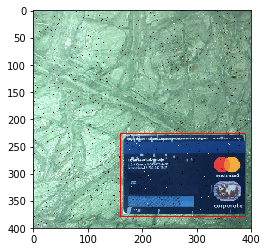

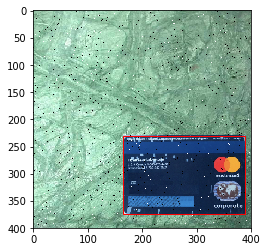

In [22]:
idx = 6
predict_labels, path = predict(annotation_validation_path, idx)
_show_image_path(annotation_validation_path,idx,predict_labels[0])
_show_image_path(annotation_validation_path,idx)

In [23]:
import coremltools
#model.save('sunny_card_model.h5')
coreml_model = coremltools.converters.keras.convert('sunny_card_model.h5', input_names=['image'], image_input_names=['image'], output_names=['output'], image_scale=1/255.0)
coreml_model.save('sunny_card_model1.mlmodel')

0 : conv2d_1_input, <keras.engine.topology.InputLayer object at 0xd3b63aa58>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0xd3b63aa20>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0xd3b8a76a0>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0xd3b63ac88>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0xd3b6452e8>
5 : conv2d_2__activation__, <keras.layers.core.Activation object at 0xd3bb28dd8>
6 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0xd3b65db38>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0xd3b676390>
8 : conv2d_3__activation__, <keras.layers.core.Activation object at 0xd3bb28f28>
9 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0xd3b68e518>
10 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0xd3b6a8390>
11 : conv2d_4__activation__, <keras.layers.core.Activation object at 0xd3b91c6d8>
12 : max_pooling2d_4, <keras.layers.pooling.MaxPooling2D object at 0xd3b